# Computational Astrophics
## Coursework 1
### Candidate Number: 24697

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import time

In [2]:
# Constants
s_year = 3.1536e7      # Seconds in a year
G = 6.6743e-11         # Gravitational constant
G_year = G * s_year**2 # Gravitational constant using years for time unit
M = 1.989e30           # Mass of Sun in kg
GM_year = G_year * M   # Combine G_year & M into single constant
AU = 1.495979e11       # Astronomical unit in metres

### Question 1.a)

The aim of question 1 is to model the orbit of Halley's comet, according to the equation

$m\frac{d^2\overrightarrow{r}}{dt^2} = -\bigg(\frac{GMm}{|\overrightarrow{r}|^2}\bigg)\frac{\overrightarrow{r}}{|r|}$ (1)

where $\overrightarrow{r}$ is the vector from the Sun to the comet, $M$ is the mass of the Sun, and $m$ is the mass of the comet. It is simple to see that $m$ cancels across the equals sign, leaving a second order ODE of the form

$\frac{d^2\overrightarrow{r}}{dt^2} = -\bigg(\frac{GM}{|\overrightarrow{r}|^2}\bigg)\frac{\overrightarrow{r}}{|r|}$ (2)

where $|\overrightarrow{r}| = \sqrt{x^2 + y^2}$ in cartesian coordinates and, $\overrightarrow{r} = \begin{bmatrix}x\\y\end{bmatrix}$.

As $x$ and $y$ are orthogonal we can split (2) into two equations for $x$ and $y$ separately. Then we further split each second order ODE into a pair of coupled first order ODEs, giving a total of four equations to solve:

$ \begin{bmatrix} \frac{dx}{dt} = v_x \\ \frac{dv_x}{dt} = -\bigg(\frac{GMx}{(x^2 + y^2)^{\frac{3}{2}}}\bigg) \end{bmatrix} $ (3)

$ \begin{bmatrix} \frac{dy}{dt} = v_y \\ \frac{dv_y}{dt} = -\bigg(\frac{GMy}{(x^2 + y^2)^{\frac{3}{2}}}\bigg) \end{bmatrix} $ (4)

In order to model the equations a vectorized, fourth order, constant step size Runge-Kutta (cRK4) method is used.

In [3]:
# Single step of the 4th order Runge-Kutta method
def RK4_step(f, t, h, r):
    k1 = np.array([h * func(t, *r) for func in f])
    k2 = np.array([h * func(t + h/2, *(r + k1/2)) for func in f])
    k3 = np.array([h * func(t + h/2, *(r + k2/2)) for func in f])
    k4 = np.array([h * func(t + h, *(r + k3)) for func in f])
    return r + (1/6)*(k1 + 2*k2 + 2*k3 + k4)

# Constant step size, vectorized Runge-Kutta method
def cRK4(f, y0, t0, tf, N):
    step = abs(tf - t0) / (N - 1)
    result = [y0]
    times = [t0]

    for i in range(N):
        result.append(RK4_step(f, times[-1], step, result[-1]))
        times.append(times[-1] + step)

    return np.array(times), np.array(result)

RK4 takes five parameters:
- $f$ Array of functions to numerically approximate.
- $y_0$ Array of initial values in the same order as their respective function in f.
- $t_0$ Start point of the time period to numerically integrate.
- $t_f$ End point of the time period to numerically integrate
- $N$ Number of steps to take.

The shape of the array of functions, $f$, matches the shape of the initial values, $y0$, as each represents a differential equation to calculate the change in that variable over a time step.

First the step size is approximated and arrays for the time points and approximated points of the curve are set up. Then, the algorithm takes $N$ iterations making a RK4 step each time. The new time value and point on the curve are then appended to their respective arrays. Finally, the time and result arrays are converted to numpy ndarrays and returned from the function.

Next, the coupled differential equations (3) & (4) are defined. They receive the current state of all the variables as arguments and then return the change in the variable they refer to.

In [4]:
# Two sets of coupled eqns, 1 set each for x & y coordinates
def dX(t, x, vx, y, vy):
    return vx
def dV_X(t, x, vx, y, vy):
    return -(GM_year * x) / pow(x**2 + y**2, 1.5)

def dY(t, x, vx, y, vy):
    return vy
def dV_Y(t, x, vx, y, vy):
    return -(GM_year * y) / pow(x**2 + y**2, 1.5)

The initial conditions are set so that cRK4 can be run and then plotted. The initial conditions array is in the order $[x, v_x, y, v_y]$. Distances are measured in metres, and all time units are converted to years therefore velocities are in metres per year. It is run three times with different values of N (100, 1,000, & 10,000) over a period of 80 years. Three different values of $N$ are used to demonstrate the improvement in accuracy as $N$ increases and the step size decreases.

In [5]:
# Initial conditions
f = np.array([ dX, dV_X, dY, dV_Y ])
r = np.array([ 5.2e12, 0, 0, 2.775e10 ])

# Simulate for 80 years
# All time units converted from seconds -> years

# Apply Runge-Kutta for x values
# vals_Nk returns:
#  - Array of time arrays.
#  - Array of arrays of [x, vx, y, vy] for each time point.
print("Calculating N = 100...")
start = time.time()
t_100, vals_100 = cRK4(f, r, 0, 100, 100)
print(f"Done. ({(time.time() - start):.3f}s)")
print("Calculating N = 1k...")
start = time.time()
t_1k, vals_1k = cRK4(f, r, 0, 100, 1000)
print(f"Done. ({(time.time() - start):.3f}s)")
print("Calculating N = 10k...")
start = time.time()
t_10k, vals_10k = cRK4(f, r, 0, 100, 10000)
print(f"Done. ({(time.time() - start):.3f}s)")

Calculating N = 100...
Done. (0.003s)
Calculating N = 1k...
Done. (0.025s)
Calculating N = 10k...
Done. (0.227s)


The results are plotted below:

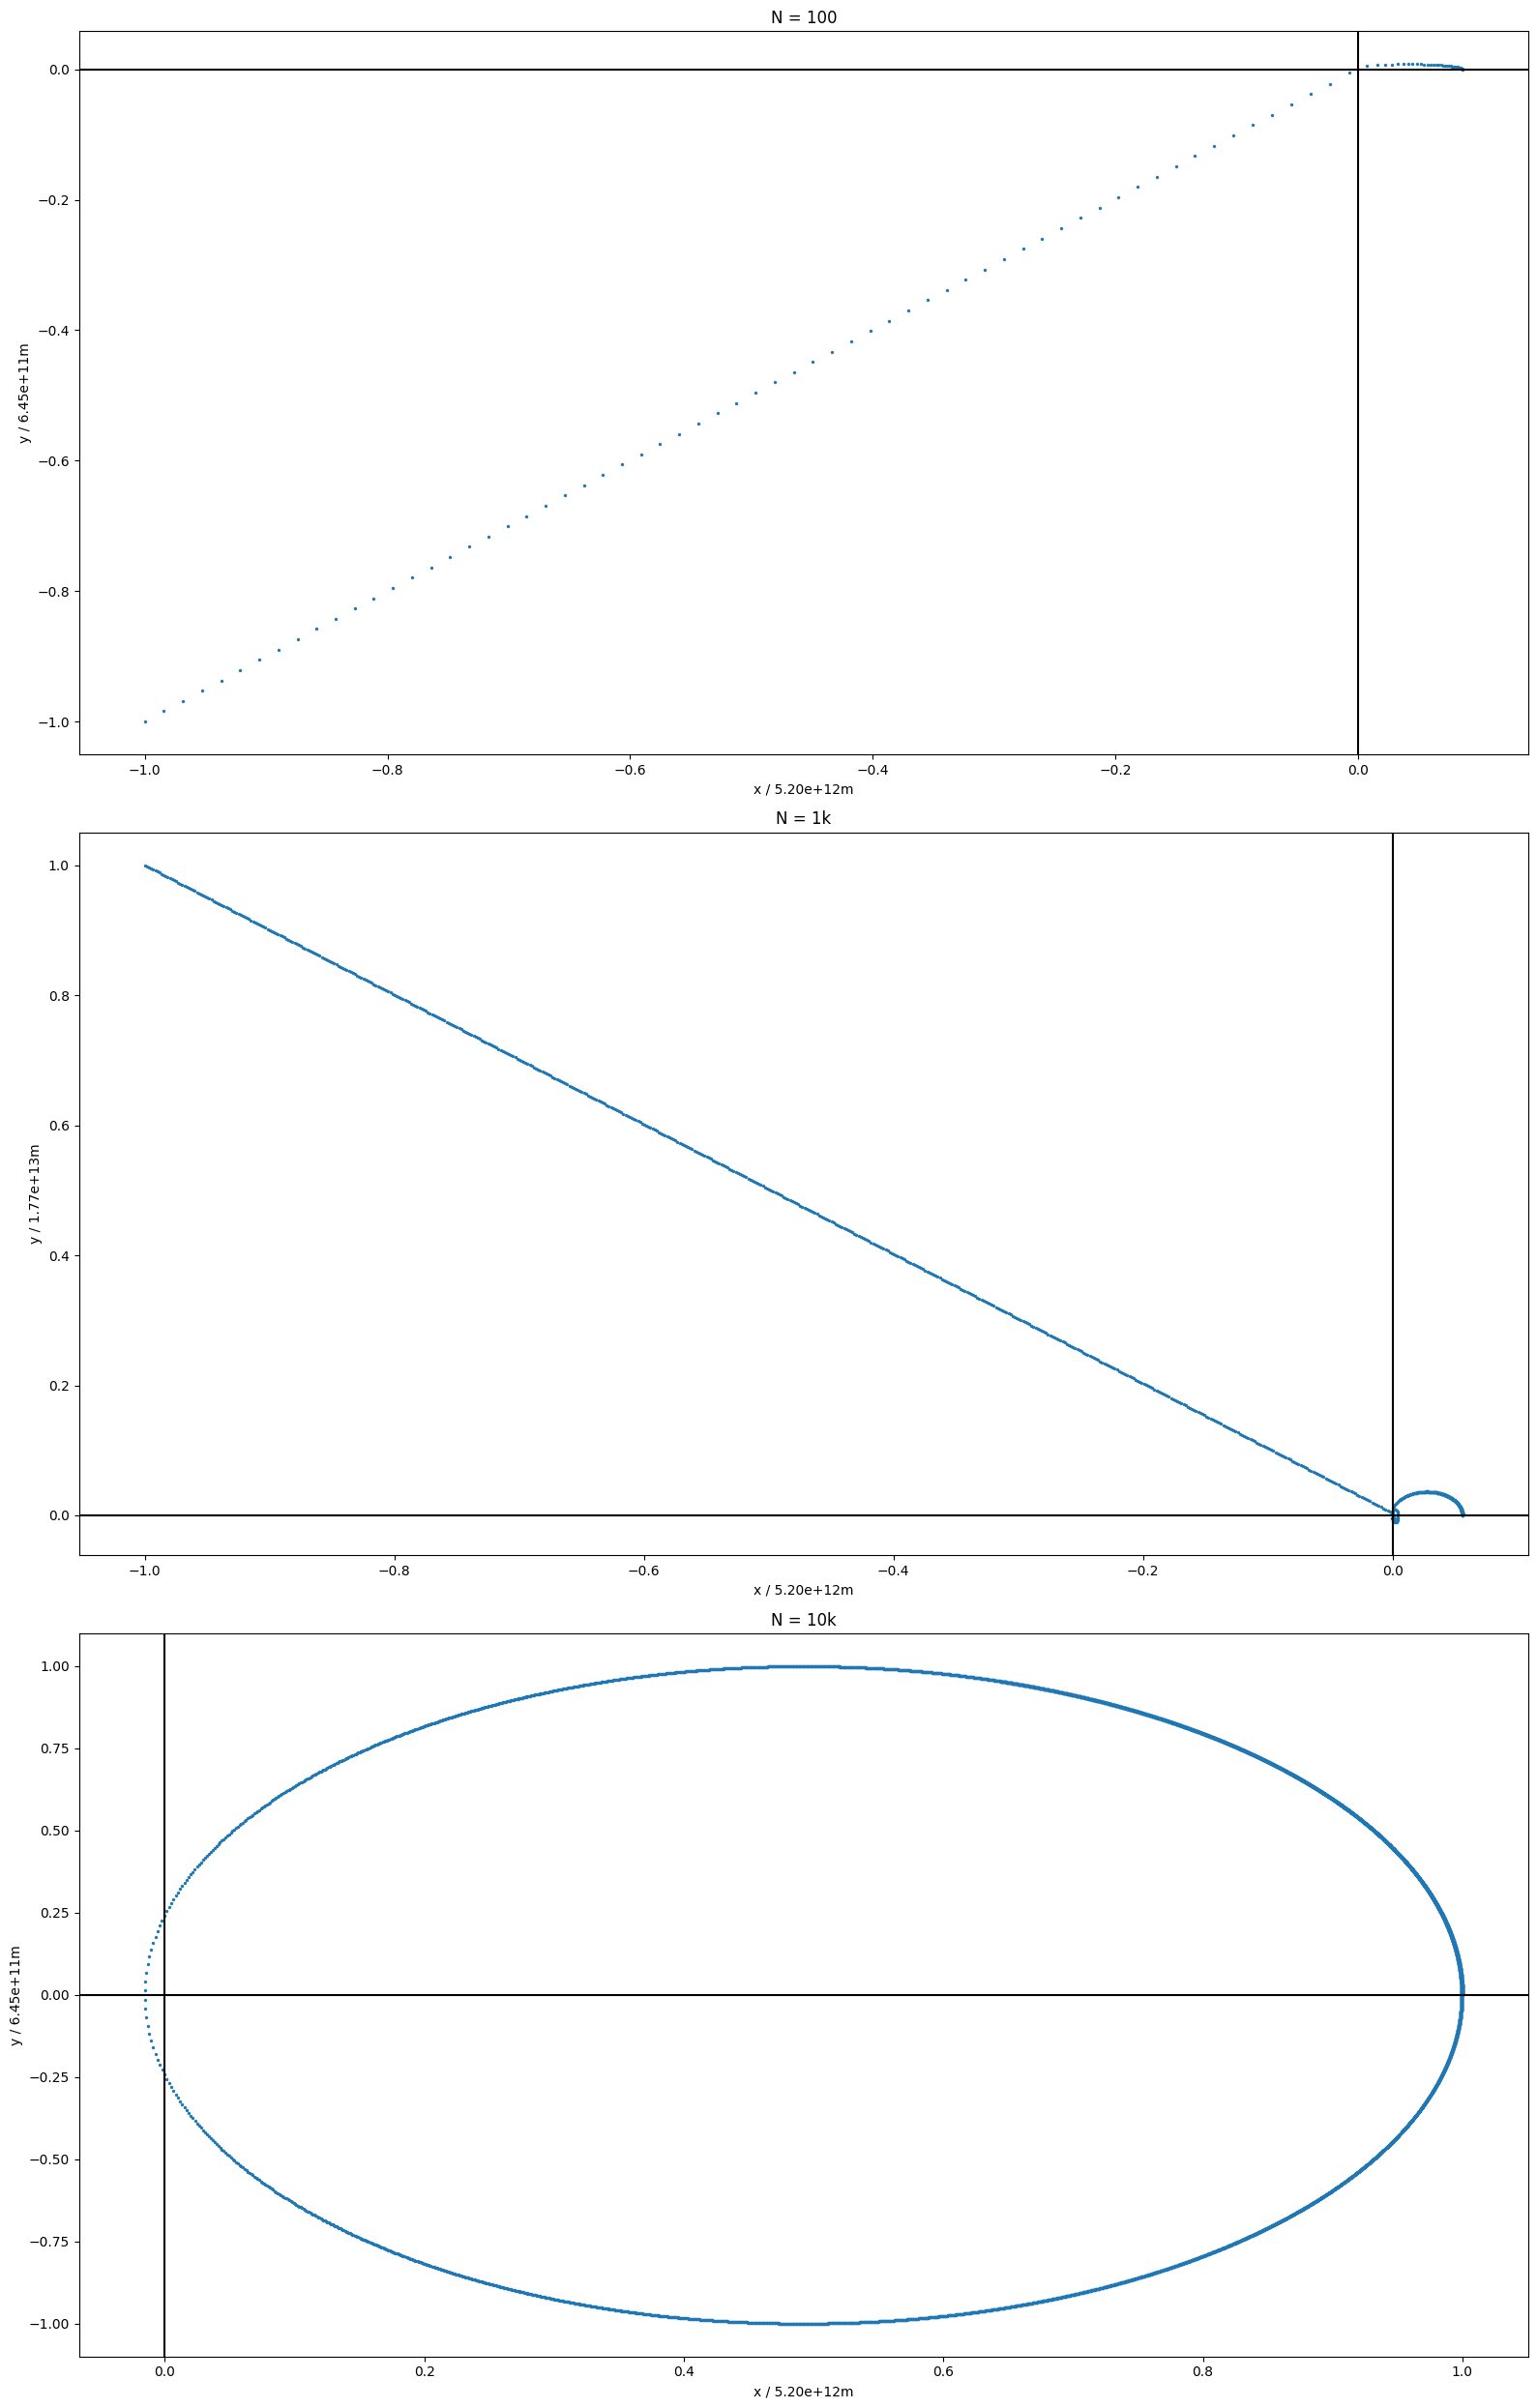

In [6]:
def normalize(arr):
    assert(type(arr) == np.ndarray)
    norm_arr = np.zeros_like(arr)
    nonzero = np.nonzero(arr)
    norm_arr[nonzero] = arr[nonzero] / max(np.abs(arr[nonzero]))
    return norm_arr

# Plot result

fig = plt.figure(figsize=(16, 25))
grid = gs.GridSpec(3,2)

ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])

ax1.set_title("N = 100")
ax1.plot(normalize(vals_100[:, 0]), normalize(vals_100[:, 2]),
         marker='o', ls='none', markersize=1.4)
ax1.set_xlabel(f"x / {max(vals_100[:, 0]):.2e}m")
ax1.set_ylabel(f"y / {max(vals_100[:, 2]):.2e}m")
ax1.axhline(0, c='k')
ax1.axvline(0, c='k')

ax2.set_title("N = 1k")
ax2.plot(normalize(vals_1k[:, 0]), normalize(vals_1k[:, 2]),
         marker='o', ls='none', markersize=1.4)
ax2.set_xlabel(f"x / {max(vals_1k[:, 0]):.2e}m")
ax2.set_ylabel(f"y / {max(vals_1k[:, 2]):.2e}m")
ax2.axhline(0, c='k')
ax2.axvline(0, c='k')

ax3.set_title("N = 10k")
ax3.plot(normalize(vals_10k[:, 0]), normalize(vals_10k[:, 2]),
         marker='o', ls='none', markersize=1.4)
ax3.set_xlabel(f"x / {max(vals_10k[:, 0]):.2e}m")
ax3.set_ylabel(f"y / {max(vals_10k[:, 2]):.2e}m")
ax3.axhline(0, c='k')
ax3.axvline(0, c='k')

plt.tight_layout()
plt.show()

### Question 1.b)

In order to improve the numerical approximation in 1.a), an adaptive time step version of the 4th order Runge-Kutta method is applied. The variable Runge-Kutta (vRK4) parameters differ from cRK4 by taking arguments for the initial step size ($init\_step$) and an error scale which defines maximum allowed discrete step error based on the previous values ($err\_scale$).

This error evaluation works as follows. First the discrete step error is calculated by evaluating the next value in the sequence from two steps of size $h$, and from a single step of size $2h$. The discrete error, $\epsilon$ is then

$\epsilon = \frac{1}{30}|y_2 - y_1|$

where $y_1$ and $y_2$ are the single and double steps respectively, and $\epsilon$ is a vector the discrete step error in each variable. Next the max allowed error for the next step is evaluated.

First the maximum values of $y_1$ and $y_2$ are found and passed to a function, $pow\_10$, which returns the power of 10 of their most significant digit. For example, 10 -> 1,  [0, 1, ..., 9] -> 0, 0.004 -> -3. The maximum error for each variable in each vector is then defined as $10^{err\_scale + log\_10(x)}$, where $x$ is the maximum value of that variable between $y_1$ and $y_2$.

If any values of $\epsilon$ are greater than the maximum error, the step size is halved. Similarly, if the error is much smaller than the threshold error, the step size is increased after checking that it won't cause the largest error to exceed the threshold.

The new function is as follows.

In [7]:
# Get array of closest powers of 10 for items in the input.
def pow_10(x):
    result = np.zeros(x.shape)
    not_zero = np.not_equal(np.abs(x), 0)
    result[not_zero] = np.floor(np.log10(np.abs(x[not_zero])))
    return result

In [8]:
def vRK4(f, y0, t0, tmax, init_step=0.001, err_scale=-6):
    if err_scale > 0:
        raise RuntimeError(f"err_scale ({err_scale}) must < 0")
    
    # Convert to numpy arrays
    f = np.array(f)
    y0 = np.array(y0)

    # Check input shapes are compatible
    assert( f.shape == y0.shape )
    # Check valid init_step
    N = int(np.floor(abs(tmax - t0) / init_step))
    if N == 0:
        raise RuntimeError( f"floor(abs({tmax} (tmax) - {t0} (t0) / {init_step} (init_step) = {N} (N), must not equal 0." )

    # Set initial conditions
    # Result has the structure: time, parameters for each respective y0 value.
    times, result = [t0], [y0]

    # Array of max errors for each parameter
    max_err_scale = np.array([10 ** (np.full_like(y0, err_scale) + pow_10(y0)) for func in f])
    epsilon_arr = [y0 * np.full_like(y0, 10 ** err_scale)]

    # The current time step value is results[i - 1, 0]
    # The next t value is set to results[i, 0] when the step size is determined.
    step = init_step
    i, t = 1, t0
    while t <= tmax:
        t = times[-1]
        params = result[-1]

        # Evaluate if error in step is too large, adjust step accordingly.
        err_too_large = True
        while err_too_large:
            # Two steps of size h
            y = RK4_step(f, t, step, params)
            y1 = RK4_step(f, t, step, y)
            # One step of size 2h
            y2 = RK4_step(f, t, 2 * step, params)

            # Check error is within tolerance
            maximum = np.maximum(np.abs(y1), np.abs(y2))
            max_err = 10 ** ( np.full_like(y0, err_scale) + pow_10(maximum) )
            err = (1/30) * np.abs(y2 - y1)
            err_too_small = np.any(np.less(err, 0.1 * max_err))
            err_too_large = np.any(np.greater(err, max_err))

            # Adjust step size
            if err_too_large:
                step /= 2
            elif err_too_small and ~np.any(np.greater(100 * err, max_err)):
                step *= 2
        
        # Write result
        times.append(t + step)
        result.append(y)
        i += 1
    
    return np.array(times), np.array(result)

The same initial values and functions are used. Three levels of precision are calculated, the number of rows ($N$) is printed, and then the result is plotted.

Calculating err_scale=0...
Done. ({time.time()-start:.3f}s)
Calculating err_scale=-3...
Done. ({time.time()-start:.3f}s)
Calculating err_scale=-6...
Done. ({time.time()-start:.3f}s)


err_scale = 0 -> steps taken = 19)
err_scale = -3 -> steps taken = 86
err_scale = -6 -> steps taken = 301


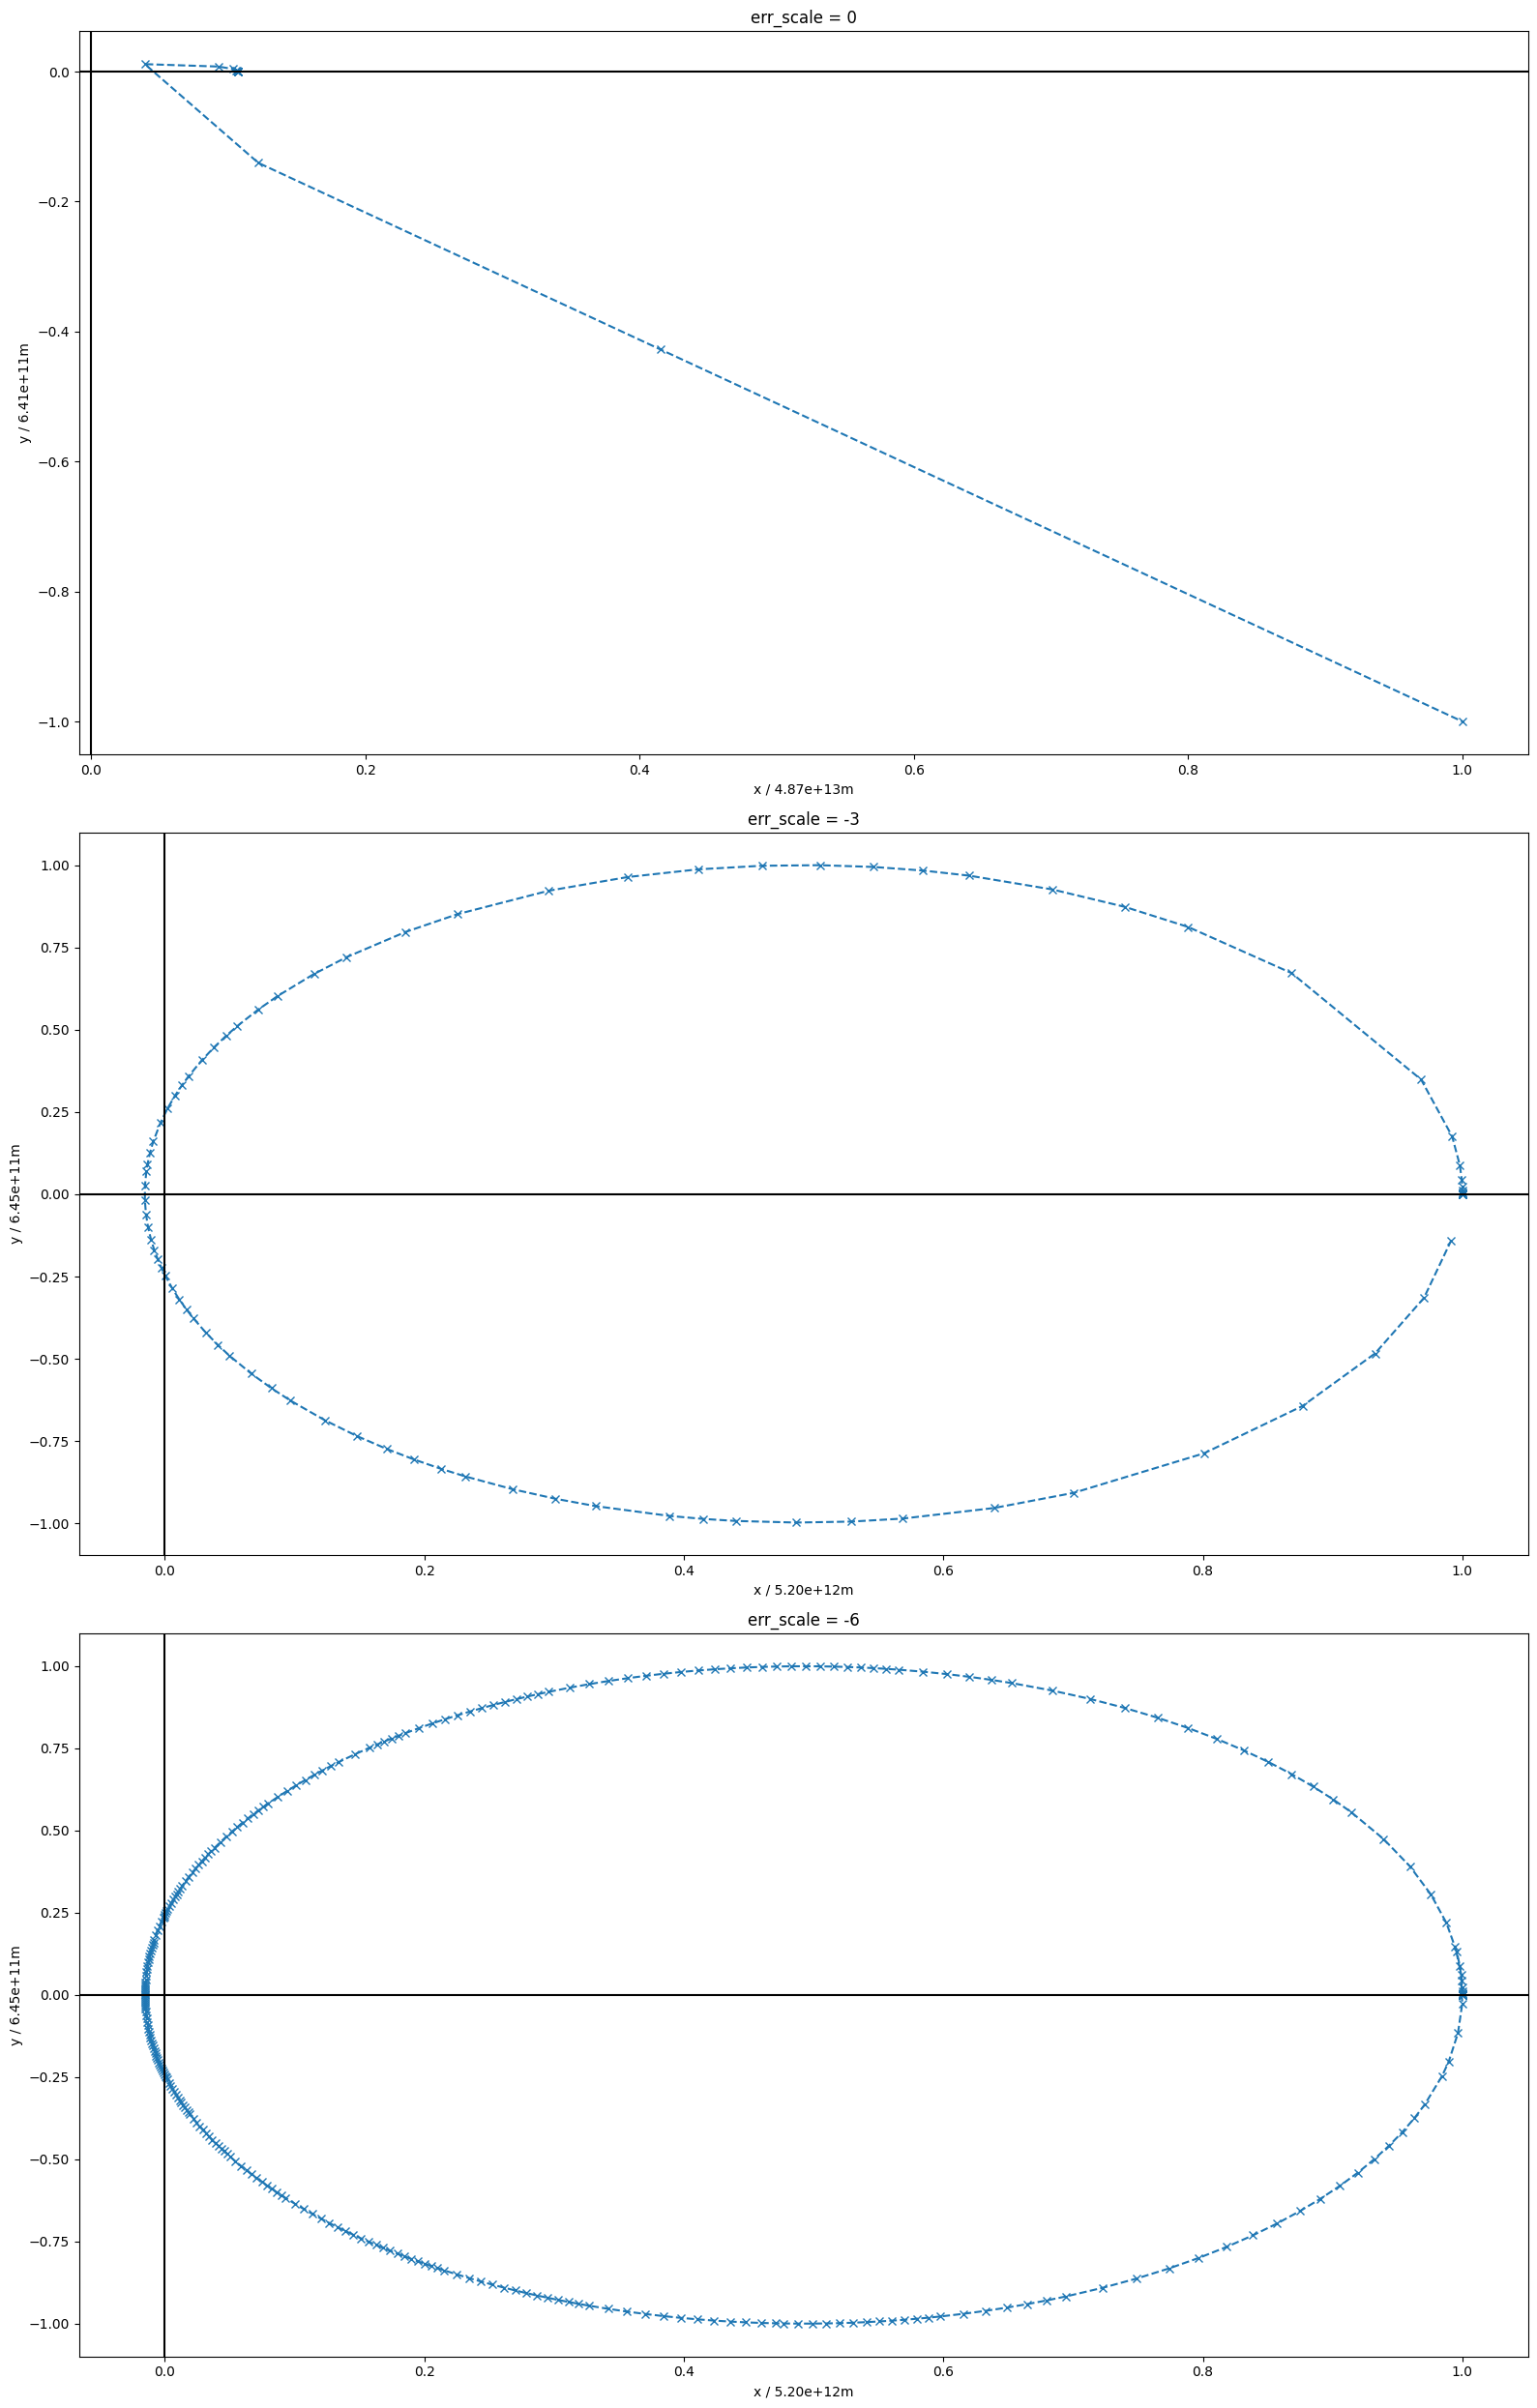

In [9]:
# Length of time to simulate in years.
years = 80

print("Calculating err_scale=0...")
start=time.time()
t_0, vals_0 = vRK4(f, r, 0, years, err_scale=0)
print("Done. ({time.time()-start:.3f}s)")
print("Calculating err_scale=-3...")
start=time.time()
t_milli, vals_milli = vRK4(f, r, 0, years, err_scale=-3)
print("Done. ({time.time()-start:.3f}s)")
print("Calculating err_scale=-6...")
t_micro, vals_micro = vRK4(f, r, 0, years, err_scale=-6)
print("Done. ({time.time()-start:.3f}s)")

print("\n")

print(f"err_scale = 0 -> steps taken = {len(t_0)})")
print(f"err_scale = -3 -> steps taken = {len(t_milli)}")
print(f"err_scale = -6 -> steps taken = {len(t_micro)}")

# Plot result

fig = plt.figure(figsize=(16, 25))
grid = gs.GridSpec(3,2)

ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])

ax1.set_title("err_scale = 0")
ax1.plot(normalize(vals_0[:, 0]), normalize(vals_0[:, 2]),
         marker='x', ls='--', markersize=6)
ax1.set_xlabel(f"x / {max(vals_0[:, 0]):.2e}m")
ax1.set_ylabel(f"y / {max(vals_0[:, 2]):.2e}m")
ax1.axhline(0, c='k')
ax1.axvline(0, c='k')

ax2.set_title("err_scale = -3")
ax2.plot(normalize(vals_milli[:, 0]), normalize(vals_milli[:, 2]),
         marker='x', ls='--', markersize=6)
ax2.set_xlabel(f"x / {max(vals_milli[:, 0]):.2e}m")
ax2.set_ylabel(f"y / {max(vals_milli[:, 2]):.2e}m")
ax2.axhline(0, c='k')
ax2.axvline(0, c='k')

ax3.set_title("err_scale = -6")
ax3.plot(normalize(vals_micro[:, 0]), normalize(vals_micro[:, 2]),
         marker='x', ls='--', markersize=6)
ax3.set_xlabel(f"x / {max(vals_micro[:, 0]):.2e}m")
ax3.set_ylabel(f"y / {max(vals_micro[:, 2]):.2e}m")
ax3.axhline(0, c='k')
ax3.axvline(0, c='k')

plt.tight_layout()
plt.show()

These graphs clearly demonstrate how the accuracy of the approximation improves with a more negative $err\_scale$. The most important result however, is how few steps it took to get a good approximation. In the constant step version it took a number of steps of the order of a thousand to get at a good approximation, whereas we have a achieved a good approximation here with just a few hundred.
We can also get a much better approximation of a longer period of time without error causing the asteroid to spiral out. Below is the numerical simulation for 10,000 years.

Completed in: 3.186s


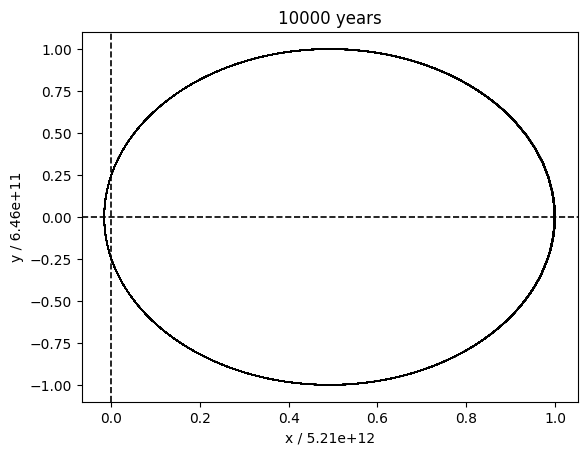

In [10]:
years = 10000
start = time.time()
t, vals = vRK4(f, r, 0, years, err_scale=-6)
print(f"Completed in: {time.time() - start:.3f}s")

plt.plot(normalize(vals[:, 0]), normalize(vals[:, 2]), "k-", linewidth=0.8)
plt.axhline(0, c='k', ls='--', linewidth=1.2)
plt.axvline(0, c='k', ls='--', linewidth=1.2)
plt.xlabel(f"x / {max(vals[:, 0]):.2e}")
plt.ylabel(f"y / {max(vals[:, 2]):.2e}")
plt.title(f"{years} years")
plt.show()

### Question 2.a)

The generalised equation for a set of $N$ bodies gravitationally interacting with each other can be expressed as

$ \ddot{\overrightarrow{r_i}} = - \sum_{j = 1}^N \frac{G m_j (\overrightarrow{r_i} - \overrightarrow{r_j})}{|\overrightarrow{r_i} - \overrightarrow{r_j}|^3}$ (5)

for $j \neq i$.

As before, second order ODEs can be broken into two first order ODEs,

$\begin{bmatrix} \dot{\overrightarrow{r_i}} = \overrightarrow{v_i} \\ \dot{\overrightarrow{v_i}} = - \Sigma_{j=1}^N \frac{G m_j (\overrightarrow{r_i} - \overrightarrow{r_j}}{|\overrightarrow{r_i} - \overrightarrow{r_j}|^3} \end{bmatrix}$ (6)

for $j \neq i$.

For the case of a three body problem of two orbiting bodies and a fixed central mass, this becomes three pairs of coupled ODEs with the pair for the central mass returning constant values for position and velocity. Alternatively,
if the central mass is allowed to move it is three pairs of coupled equations as before.

In order to model this set of equations, I decided to implement three classes which would handle different parts of the system.

 - SolarObject (Inherited by FixedObject): Manages the current name, mass, position, and velocity. Calculates the next state for this object from a given set of previous states of the overarching system.
 - Orbit: Manages the time, position, and velocity history for a given SolarObject.
 - System: Manages multiple orbits, the time step, and time. Runs and plots simulations for a specified time period using a 4th order Runge-Kutta method.

These are implemented below.

In [11]:
def magnitude(r): # Magnitude of a given vector
    return np.sqrt(np.sum(np.square(r), axis=None))

In [12]:
class SolarObject:
    def __init__(self, object_name, mass, position, velocity):
        assert(type(position) == list or type(position) == np.ndarray)
        assert(type(velocity) == list or type(velocity) == np.ndarray)
        self.name = object_name     # Name to distinguish between objects in data
        self.m = mass               # Mass of object
        self.r = np.array(position) # [x, y] vector. Relative to orbit CoM
        self.v = np.array(velocity) # [v_x, v_y] vector.
        return None
    def __repr__(self):
        return f"SolarObject: {mass: {self.m}, position: {self.r}, velocity: {self.v}\}"
    def __str__(self):
        return f"SolarObject: (mass: {self.m}, position: {self.r}, velocity: {self.v})"
    def __eq__(self, other):
        return type(self) == type(other) and self.name == other.name
    def __ne__(self, other):
        return not self.__eq__(other)

    # Euclidean distance between this SolarObject & a given position
    def distance(self, position):
        return np.sqrt(np.sum(np.square(self.r - position), axis=None))
    
    # Vector between this object & another.
    def rel_position(self, obj):
        return obj.r - self.r
    
    # Full state of object
    def full_state(self):
        return (self.name, self.m, self.r, self.v)
    
    # Position and velocity vectors of this object
    def current_state(self):
        return np.array([self.r, self.v])
    # object_states = [ [[pos], [vel]], ...]
    
    # Calculate the ith dimension of the next state of this SolarObject from the current states
    # of all objects in the system.
    def next_state(self, i, object_masses, object_states):
        r, v = object_states[i]
        # Change in position over a time step ~= velocity
        dr_next = v
        # Change in velocity over a time step ~= sum of accelerations on object
        dv_next = -np.sum(
        [
            (G * mass * (r - pos)) / self.distance(pos)**3
            for j, (mass, (pos, vel)) in enumerate(zip(object_masses, object_states))
            if i != j
        ], axis=0)
        return (dr_next, dv_next)
    
    # Update the current state of the object
    def update_state(self, mass=None, state=None):
        position = None
        velocity = None
        if state is not None:
            position, velocity = state
        if mass is not None:
            self.m = mass
        if position is not None:
            self.r = position
        if velocity is not None:
            self.v = velocity
        return None
    
    # Clear the object
    def clear_state(self):
        self.m = None
        self.r = None
        self.v = None

Planet = SolarObject
   
# Same as SolarObject, however position and velocity are fixed in place.
class FixedObject(SolarObject):
    def __init__(self, object_name, mass, position, velocity):
        super().__init__(object_name, mass, position, velocity)
        return None
    # Fixed version of next_state
    def next_state(self, i, object_masses, object_states):
        return np.array([self.r, self.v])
    # Fixed version of update_state
    def update_state(self, mass=None, state=None):
        return None
    # Force change function to manipulate state outside of calculations
    def force_change(self, mass, position, velocity):
        self.m = mass
        self.r = position
        self.v = velocity
        return None

Star = FixedObject

In [13]:
class Orbit:
    def __init__(self, obj, history = False):
        assert(type(obj) == SolarObject or type(obj) == FixedObject)
        self.o = obj         # Object in this orbit
        # Boolean to check if previous positions & velocities should be stored
        self.store_history = history
        self.times = [0]             # All previous times, if store_history is True, else current only
        self.positions =  [self.o.r] # All previous positions, if store_history is True, else current only
        self.velocities = [self.o.v] # All previous velocities, if store_history is True, else current only
        return None
    
    # Retrieve individual parts of underling object state
    def name(self):
        return self.o.name
    def mass(self):
        return self.o.m
    def position(self):
        return self.o.r
    def velocity(self):
        return self.o.v
    
    # Retrieve entire history of orbit
    def history(self):
        return (np.array(self.times), np.array(self.positions), np.array(self.velocities))
    
    # Retrieve full state of SolarObject owned by this orbit
    def full_state(self):
        return self.o.full_state()
    
    # Retrieve position and velocity data of SolarObject owned by this orbit
    def current_state(self):
        return self.o.current_state()
    
    # Calculate next state of SolarObject owned by this orbit
    def next_state(self, i, object_masses, object_states):
        return self.o.next_state(i, object_masses, object_states)
    
    # Set current state of this orbit, including underlying SolarObject
    def set_state(self, time=None, mass=None, state=None):
        position = None
        velocity = None
        if state is not None:
            position, velocity = state
            self.positions[-1] = position
            self.velocities[-1] = velocity
        if time is not None:
            self.times[-1] = time
        if mass is not None and state is not None:
            self.o.update_state(mass, state)
        elif mass is not None:
            self.o.update_state(mass=mass)
        elif state is not None:
            self.o.update_state(state=state)
        return None
        
    # Specify the next state of this object, inluding underlying SolarObject
    def update_state(self, time=None, mass=None, state=None):
        position = None
        velocity = None
        if state is not None:
            position, velocity = state
        if self.store_history:
            if time is not None:
                self.times.append(time)
            if position is not None:
                self.positions.append(position)
            if velocity is not None:
                self.velocities.append(velocity)
        else:
            if time is not None:
                self.times[0] = time
            if position is not None:
                self.positions[0] = position
            if velocity is not None:
                self.velocities[0] = velocity
        self.o.update_state(mass=mass, state=state)
        return None
    
    # Clear this orbit, and underlying SolarObject
    def clear_state(self):
        self.o.clear_state()
        self.o = None
        self.history = None
        self.times = None
        self.positions = None
        self.velocities = None

In [14]:
class System:
    def __init__(self):
        self.orbits = []       # Orbits in this system
        self.time = 0          # Current time
        self.time_step = 0.001 # Current time step
        return None
    
    # Add a new object into a system
    def add(self, orbit):
        assert(type(orbit) == Orbit)
        if len(self.orbits) == 0:
            self.orbits=[orbit]
            self.time = 0
            self.time_step = 0.001
            return None
        self.orbits.append(orbit)
        return None
    
    # Get / set the current time step
    def step(self, step=None):
        if step is not None:
            self.time_step = step
        return self.time_step
    
    # Perform single RK4 step on all planets
    def RK4_step(self, h, object_masses, current_states):
        k1 = h * np.array([
            orbit.next_state(i, object_masses, current_states)
            for i, orbit in enumerate(self.orbits)
        ])
        k2 = h * np.array([
            orbit.next_state(i, object_masses, current_states + k1 / 2)
            for i, orbit in enumerate(self.orbits)
        ])
        k3 = h * np.array([
            orbit.next_state(i, object_masses, current_states + k2 / 2)
            for i, orbit in enumerate(self.orbits)
        ])
        k4 = h * np.array([
            orbit.next_state(i, object_masses, current_states + k3)
            for i, orbit in enumerate(self.orbits)
        ])
        return np.array([
            state + (1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
            for state, k_1, k_2, k_3, k_4 in zip(current_states, k1, k2, k3, k4)
        ])
    
    # Convert provided object_states into the centre-of-mass frame.
    def com_converter(self, object_masses, object_states):
        m_total_reciprocal = 1 / np.sum(object_masses, axis=None)
        
        # Centre of mass (com) formula is same for position and velocity
        # Therefore apply to all parts of object_states
        com = np.sum(
            np.array([
                m_i * r_i * m_total_reciprocal
                for m_i, r_i in zip(object_masses, object_states)
            ]),
            axis=0
        )
        
        return object_states - com
    
    # Project system forwards by 'time' amount.
    def simulate(self, time, rtol=1e-05, atol=1e-08, err_scale=-6, com=True):
        initial_time = self.time
        final_time = self.time + time
        object_masses = np.array([orbit.mass() for orbit in self.orbits])
        
        if com: # Convert initial position into centre-of-mass
            current_states = np.array([orbit.current_state() for orbit in self.orbits])
            com_states = self.com_converter(object_masses, current_states)
            for orbit, state in zip(self.orbits, com_states):
                orbit.set_state(mass=orbit.mass(), state=state)
        
        # Variational step size, 4th order Runge-Kutta method
        while self.time <= final_time:
            current_states = np.array([orbit.current_state() for orbit in self.orbits])
            
            err_too_large = True
            while err_too_large:
                step_h_1 = self.RK4_step(self.time_step, object_masses, current_states)
                step_h_2 = self.RK4_step(self.time_step, object_masses, step_h_1)
                
                step_2h = self.RK4_step(2 * self.time_step, object_masses, current_states)

                max_err = rtol * np.maximum(np.abs(step_h_2), np.abs(step_2h)) + atol
                step_err = (1/30) * np.abs(step_2h - step_h_2)
                
                err_too_large = np.any(np.greater(step_err, max_err))
                err_too_small = np.any(np.less(1000 * step_err, max_err))
                
                if err_too_large:
                    self.time_step /= 2
                elif err_too_small:
                    self.time_step *= 2
            if com:
                step_h_2 = self.com_converter(object_masses, step_h_2)
                
            # Update orbit states
            for orbit, state in zip(self.orbits, step_h_2):
                orbit.update_state(time=self.time, state=state)
            self.time += self.time_step

        return None
    
    # Retrieve current states of all Orbits in the System
    def current_state(self):
        return np.array([orbit.current_state() for orbit in self.orbits])
    
    # Retrieve full states of all Orbits in the System
    def full_state(self):
        return np.array([ orbit.full_state() for orbit in self.orbits])
    
    # Retrieve full history of all Orbits in the System
    def history(self, i=None):
        if i is None:
            return np.array([ orbit.history() for orbit in self.orbits ])
        return self.orbits[i].history()
    
    # Plot Orbits in the system
    def plot_history(self, figsize=(8,8), title="",
                     marker='o', marker_sizes=None,
                     ls='--', linewidth=1.0,
                     scale=None, norm_scale=False,
                     units=None, fname=None):
        if type(marker_sizes) == list:
            assert(len(marker_sizes) == len(self.orbits))
        elif type(marker_sizes) == np.ndarray:
            assert(len(marker_sizes.shape) == 1 and
                   marker_sizes.shape[0] == len(self.orbits))
        elif marker_sizes is not None:
            marker_sizes = [marker_sizes] * len(self.orbits)
        
        fig = plt.figure(figsize=figsize)
        
        scale_x = 1
        scale_y = 1
        units_x = ""
        units_y = ""
            
        if norm_scale:
            nonzero_x = np.nonzero(x)
            nonzero_y = np.nonzero(y)
            x[nonzero_x] = x[nonzero_x] / max(x[nonzero_x])
            y[nonzero_y] = y[nonzero_y] / max(y[nonzero_y])
            scale_x = max(x[nonzero_x])
            scale_y = max(y[nonzero_y])
        
        for i, orbit in enumerate(self.orbits):
            t, p, v = orbit.history()
            x, y = p[:, 0], p[:, 1]
            vx, vy = v[:, 0], v[:, 1]
        
            if units is not None and scale is not None:
                assert(type(units) == np.ndarray or type(units) == list)
                if type(units) == list:
                    assert(len(units) == 2)
                if type(units) == np.ndarray:
                    assert(len(units.shape) == 1 and units.shape[-1] == 2)
                assert(type(units[0]) == str)
                units_x = units[0]
                units_y = units[1]
            
                if type(scale) == np.ndarray:
                    assert(len(scale.shape) == 1 and len(scale.shape[0]) == 2)
                if type(scale) == list or type(scale) == np.ndarray:
                    x = x / scale[0]
                    y = y / scale[1]
                    scale_x = scale[0]
                    scale_y = scale[1]
            
                units_x = f"/ {scale_x:.2e}{units[0]}"
                units_y = f"/ {scale_y:.2e}{units[1]}"
            else:
                units_x = ""
                units_y = ""
            
            p = plt.plot(x[-1], y[-1], marker=marker, markersize=float(marker_sizes[i]), ls='none', label=orbit.name())
            plt.plot(x, y, c=p[0].get_color(), ls=ls, linewidth=linewidth)

            plt.xlabel(f"x {units_x}")
            plt.ylabel(f"y {units_y}")
        
        if fname is not None:
            plt.savefig(fname)
        
        plt.title(title)
        plt.axis("equal")
        plt.legend()
        plt.show()
        
        return None
    
    def clear_state(self):
        for o in self.orbits:
            o.clear_state()
        self.orbits = []
        self.time = None
        self.time_step = None
        return None

The first system to model consists of the Sun, planet $p1$, and planet $p2$. The planets have masses of $10^{-3} M_{\odot}$ and $4x10^{-2} M_{\odot}$ respectively. They have orbital radii of $2.52 AU$ and $5.24 AU$ respectively. These values allow us to estimate the initial velocity of the planets, if we assume near circular orbits and that the mass of the Sun dominates the system, it can be calculated from the equation,

$v = \sqrt{\frac{GM_{\odot}}{r}}$ (7)

where $r$ is the orbital radius of the object.

In this first simulation, the Sun is treated as a non-fixed SolarObject leading to the motion seen in the model. This, and all following simulations, are performed over 50 years.

Simulating p1, p2 with non-fixed Sun position...
Done. (2.064s)


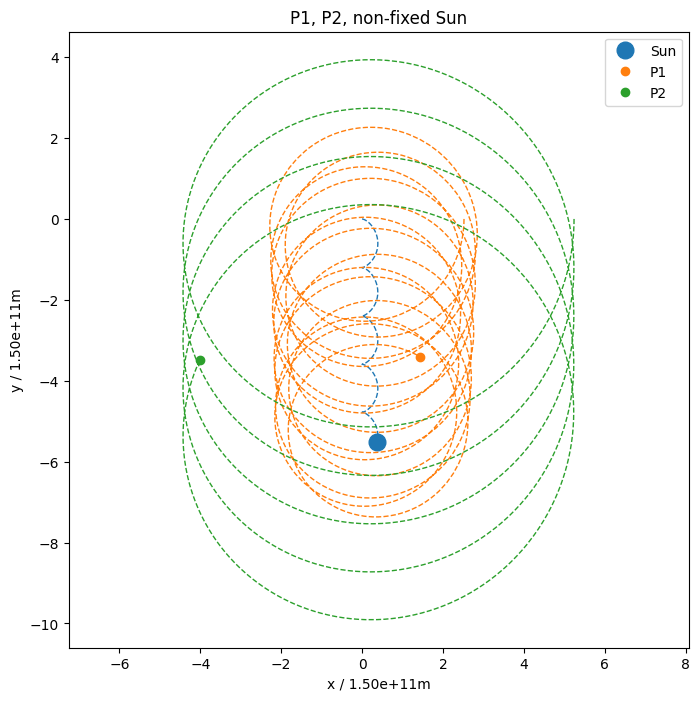

In [15]:
# Constants for 2.a
m1 = 1 * (10 ** -3) * M
m2 = 4 * (10 ** -2) * M

# Initial radius
a1 = 2.52 * AU
a2 = 5.24 * AU

# Assuming they begin at [a1, 0], [a2, 0] at t=0
r1 = np.array([a1, 0])
r2 = np.array([a2, 0])
v1_init = np.sqrt(G * M / a1)
v2_init = np.sqrt(G * M / a2)

v1 = np.array([0, -v1_init])
v2 = np.array([0, -v2_init])

# Setting up system for 2.a
Sun = Planet("Sun", M, [0, 0], [0, 0])
p1 = Planet("P1", m1, r1, v1)
p2 = Planet("P2", m2, r2, v2)

# Setting up the solar system
solar_system1 = System()
solar_system1.add(Orbit(Sun, True))
solar_system1.add(Orbit(p1, True))
solar_system1.add(Orbit(p2, True))

years = 50
time_seconds = years * s_year

start = time.time()
print("Simulating p1, p2 with non-fixed Sun position...")
solar_system1.simulate(time_seconds, rtol=1e-8, atol=1e-10, com=False)
print(f"Done. ({time.time() - start:.3f}s)")

solar_system1.plot_history(title="P1, P2, non-fixed Sun", marker_sizes=[12, 6, 6],
                           units=['m','m'], scale=[AU, AU])

solar_system1.clear_state()

The flexibility of this object oriented position allows an alternative, FixedObject to be used for the Sun instead of a SolarObject.

The following model is the system if the position and velocity of the Sun are fixed.

Simulating p1, p2 with fixed Sun position...
Done. (1.159s)


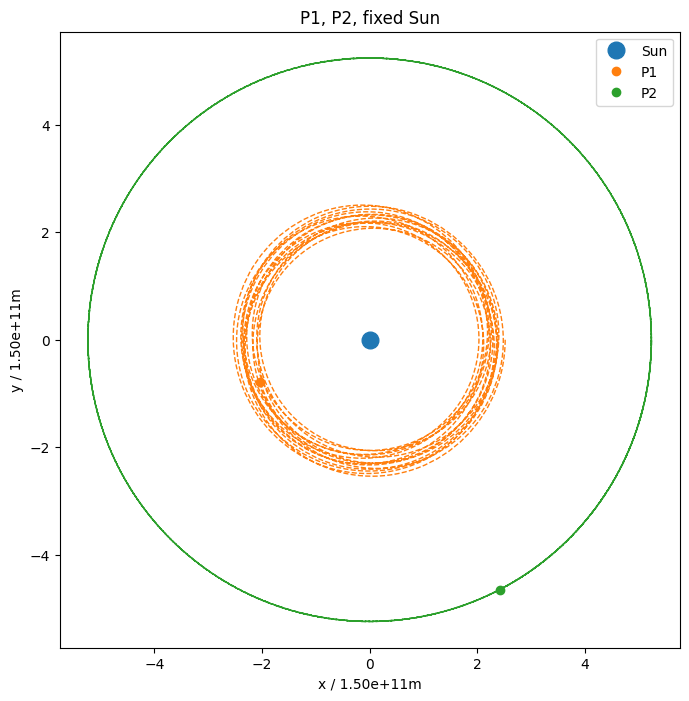

In [16]:
Sun_fixed = FixedObject("Sun", M, [0, 0], [0, 0])
p1 = Planet("P1", m1, r1, v1)
p2 = Planet("P2", m2, r2, v2)

solar_system1.add(Orbit(Sun_fixed, True))
solar_system1.add(Orbit(p1, True))
solar_system1.add(Orbit(p2, True))

print("Simulating p1, p2 with fixed Sun position...")
start = time.time()
solar_system1.simulate(time_seconds, rtol=1e-8, atol=1e-10, com=False)
print(f"Done. ({time.time() - start:.3f}s)")

solar_system1.plot_history(title="P1, P2, fixed Sun", marker_sizes=[12, 6, 6],
                           units=['m','m'], scale=[AU, AU])

solar_system1.clear_state()

In the next model real data for Jupiter and Saturn are used to simulate a system comprised the Sun, Jupiter, and Saturn.

The formula,

$r_{perihelion} = a(1 - e)$, (8)

is used to calculate the positions of the planets given an average radius, $a$, and eccentricity, $e$, and from there its velocity too.

The position of the Sun is not fixed, however the different initial mass and velocity conditions lead to a more stable orbit than the orbit of p1 and p2.

Simulating Sun, Jupiter, and Saturn system...
Done. 1.799


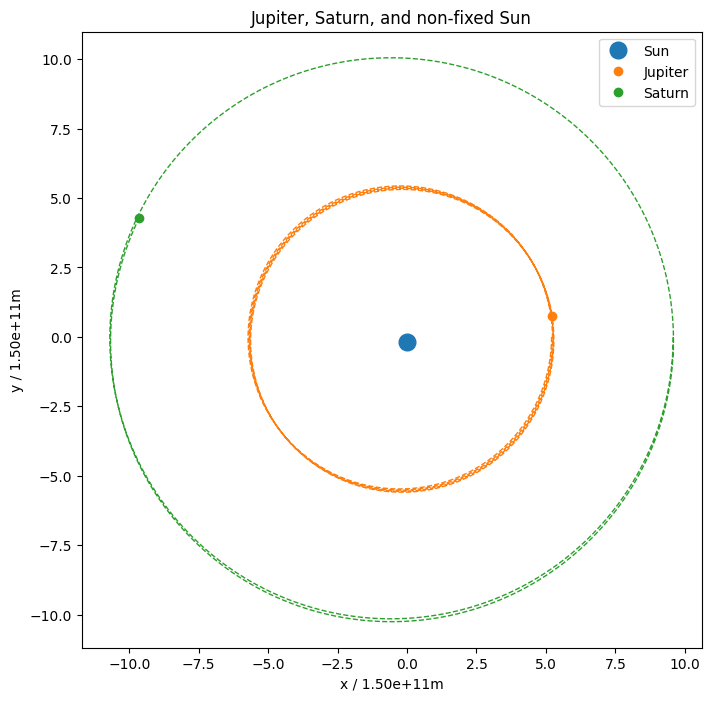

In [17]:
def r_perihelion(a, e):
    return (1 - e) * a
def r_aphelion(a, e):
    return (1 + e) * np.sqrt(a * (1 - e))

j_eccentricity = 0.049
s_eccentricity = 0.057

j_m = 1.898e27
s_m = 5.683e26

j_r = np.array([r_perihelion(5.204 * AU, j_eccentricity), 0])
s_r = np.array([r_perihelion(9.583 * AU, s_eccentricity), 0])

j_v = np.array([0, -np.sqrt(G * M / r_perihelion(5.204 * AU, j_eccentricity))])
s_v = np.array([0, -np.sqrt(G * M / r_perihelion(9.583 * AU, s_eccentricity))])

Sun = SolarObject("Sun", M, [0, 0], [0, 0])
jupiter = Planet("Jupiter", j_m, [5.204 * AU, 0], j_v)
saturn = Planet("Saturn", s_m, [9.583 * AU, 0], s_v)

solar_system2 = System()
solar_system2.add(Orbit(Sun, True))
solar_system2.add(Orbit(jupiter, True))
solar_system2.add(Orbit(saturn, True))

print("Simulating Sun, Jupiter, and Saturn system...")
start = time.time()
solar_system2.simulate(time_seconds, rtol=1e-10, atol=1e-10, com=False)
print(f"Done. {time.time() - start:.3f}")

solar_system2.plot_history(title="Jupiter, Saturn, and non-fixed Sun", marker_sizes=[12, 6, 6],
                           units=['m','m'], scale=[AU, AU])

solar_system2.clear_state()

### Question 2.b)

In order to transform the system into the centre-of-mass (COM) frame, each position and velocity must be calculated relative to it. The centre of mass position and velocity can be calculated from the equations,

$\overrightarrow{r_{cm}}(t) = \Sigma_i \frac{m_i}{M_{total}} \overrightarrow{r_{i}}(t)$,

and,

$\overrightarrow{v_{cm}}(t) = \Sigma_i \frac{m_i}{M_{total}} \overrightarrow{r_{i}}(t)$,

where $M_{total}$ is the sum of the mass in the system.

$\overrightarrow{r_{cm}}(t)$ and $\overrightarrow{v_{cm}}(t)$ are then calculated for each state the system reaches, and then subtracted from the current state to bring it into the COM frame of reference.

The simulation system used so far can then account for the COM frame by converting the initial conditions to the COM frame, then proceeding with the same RK4 procedure and converting to the COM frame after every time step.

The same systems as above have been re-simulated in the COM frame below.

Simulating Sun, p1, and p2 in the centre-of-mass frame...
Done. (8.736)


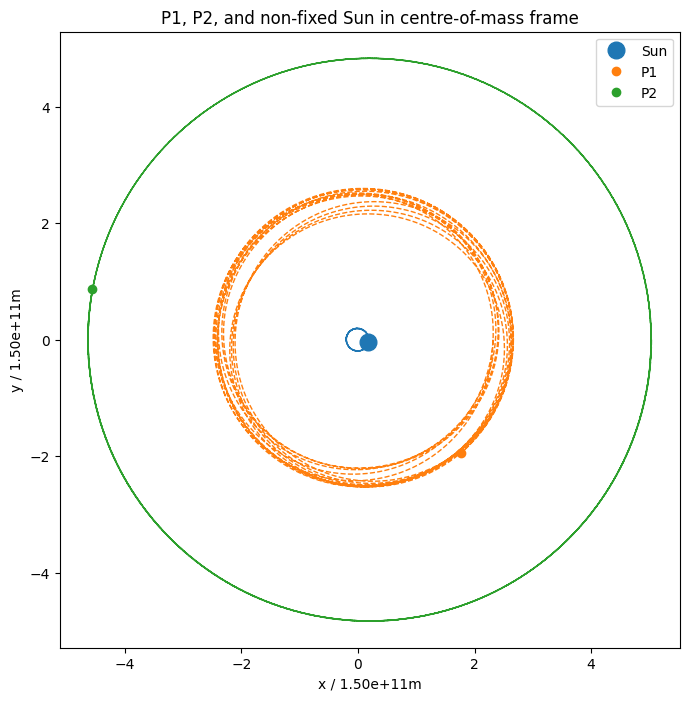

In [18]:
# Constants for 2.b
m1 = 1 * (10 ** -3) * M
m2 = 4 * (10 ** -2) * M

# Initial radius
a1 = 2.52 * AU
a2 = 5.24 * AU

# Assuming they begin at [a1, 0], [a2, 0] at t=0
r1 = np.array([a1, 0])
r2 = np.array([a2, 0])
v1_init = np.sqrt(G * M / a1)
v2_init = np.sqrt(G * M / a2)

v1 = np.array([0, -v1_init])
v2 = np.array([0, -v2_init])

Sun = Planet("Sun", M, [0, 0], [0, 0])
p1 = Planet("P1", m1, r1, v1)
p2 = Planet("P2", m2, r2, v2)

solar_system3 = System()
solar_system3.add(Orbit(Sun, True))
solar_system3.add(Orbit(p1, True))
solar_system3.add(Orbit(p2, True))

print("Simulating Sun, p1, and p2 in the centre-of-mass frame...")
start = time.time()
solar_system3.simulate(time_seconds, rtol=1e-12, atol=1e-10)
print(f"Done. ({time.time() - start:.3f})")

solar_system3.plot_history(title="P1, P2, and non-fixed Sun in centre-of-mass frame",
                           marker_sizes=[12, 6, 6],
                           units=['m','m'], scale=[AU, AU])

solar_system3.clear_state()

Simulating Sun, Jupiter, and Saturn system in centre-of-mass frame...
Done. 2.016


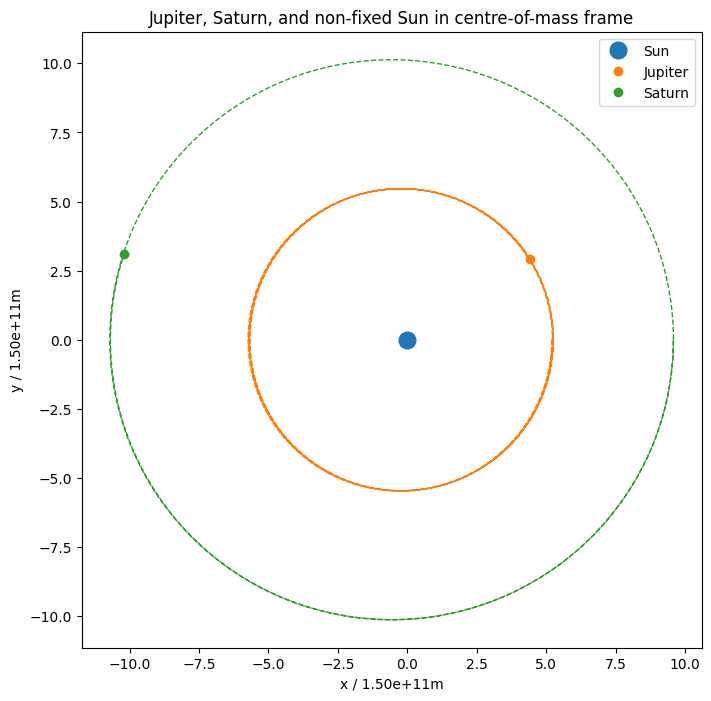

In [19]:
def r_perihelion(a, e):
    return (1 - e) * a
def r_aphelion(a, e):
    return (1 + e) * np.sqrt(a * (1 - e))

j_eccentricity = 0.049
s_eccentricity = 0.057

j_m = 1.898e27
s_m = 5.683e26

j_r = np.array([r_perihelion(5.204 * AU, j_eccentricity), 0])
s_r = np.array([r_perihelion(9.583 * AU, s_eccentricity), 0])

j_v = np.array([0, -np.sqrt(G * M / r_perihelion(5.204 * AU, j_eccentricity))])
s_v = np.array([0, -np.sqrt(G * M / r_perihelion(9.583 * AU, s_eccentricity))])

Sun = SolarObject("Sun", M, [0, 0], [0, 0])
jupiter = Planet("Jupiter", j_m, [5.204 * AU, 0], j_v)
saturn = Planet("Saturn", s_m, [9.583 * AU, 0], s_v)

solar_system2 = System()
solar_system2.add(Orbit(Sun, True))
solar_system2.add(Orbit(jupiter, True))
solar_system2.add(Orbit(saturn, True))

print("Simulating Sun, Jupiter, and Saturn system in centre-of-mass frame...")
start = time.time()
solar_system2.simulate(time_seconds, rtol=1e-10, atol=1e-10, com=True)
print(f"Done. {time.time() - start:.3f}")

solar_system2.plot_history(title="Jupiter, Saturn, and non-fixed Sun in centre-of-mass frame",
                           marker_sizes=[12, 6, 6],
                           units=['m','m'], scale=[AU, AU])

solar_system2.clear_state()

The flexibility of this class system allows us to set up some more complex systems. An example is the following binary system, it is inspired by the three stars of the Alpha Centauri system. However, values have been changed so it could be simulated in a reasonable time.

Simulating modified Alpha Centauri system in COM frame...
Done. (1.287)


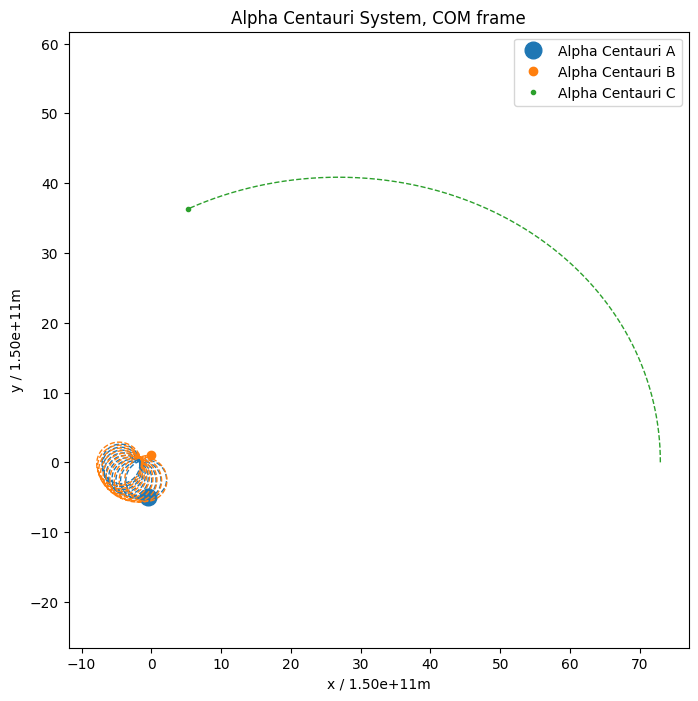

In [20]:
# Eccentricities
e_ac_A = 0
e_ac_B = 0.51947
e_ac_C = 0.50

# Masses
m_ac_A = 1.0788 * M
m_ac_B = 0.9092 * M
m_ac_C = 0.122  * M

# Positions
r_ac_A = np.array([0, 0])
r_ac_B = np.array([5.66909522 * AU, 0])
r_ac_C = np.array([80 * AU, 0])

# Velocities
v_ac_A = np.array([0, 0])
v_ac_B = np.array([0, -np.sqrt(G * M / r_perihelion(r_ac_B[0], e_ac_B))])
v_ac_C = np.array([0, -np.sqrt(G * M / r_perihelion(r_ac_C[0], e_ac_C))])

# Proxima Centauri A, B, & C
ac_A = SolarObject("Alpha Centauri A", m_ac_A, r_ac_A, v_ac_A)
ac_B = SolarObject("Alpha Centauri B", m_ac_B, r_ac_B, v_ac_B)
ac_C = SolarObject("Alpha Centauri C", m_ac_C, r_ac_C, v_ac_C)

alpha_centauri = System()
alpha_centauri.add(Orbit(ac_A, True))
alpha_centauri.add(Orbit(ac_B, True))
alpha_centauri.add(Orbit(ac_C, True))

duration = 100 * s_year # no. seconds in 50 years

print("Simulating modified Alpha Centauri system in COM frame...")
start = time.time()
alpha_centauri.simulate(duration, rtol=1e-8, atol=1e-10, com=True)
print(f"Done. ({time.time() - start:.3f})")

alpha_centauri.plot_history(title="Alpha Centauri System, COM frame",
                           marker_sizes=[12, 6, 3],
                           units=['m','m'], scale=[AU, AU])

alpha_centauri.clear_state()